In [1]:
!pip install -U diffusers

  Using cached diffusers-0.36.0-py3-none-any.whl.metadata (20 kB)
Using cached diffusers-0.36.0-py3-none-any.whl (4.6 MB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.27.2
    Uninstalling diffusers-0.27.2:
      Successfully uninstalled diffusers-0.27.2


In [2]:
pip install -U diffusers transformers accelerate

In [3]:
import torch
from diffusers import DiffusionPipeline
from IPython.display import display

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)
pipe = pipe.to(device)  # send model to GPU/CPU


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

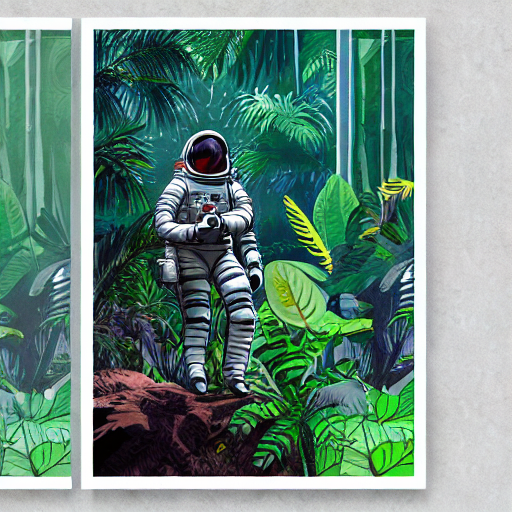

In [4]:
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

result = pipe(prompt)
image = result.images[0]  # PIL.Image

display(image)            # show in notebook

In [5]:
def generate_image(
    prompt,
    negative_prompt="",
    guidance_scale=7.5,
    num_inference_steps=30,
    seed=42,
    height=512,
    width=512,
):
    generator = torch.Generator(device=device).manual_seed(seed)

    result = pipe(
        prompt,
        negative_prompt=negative_prompt if negative_prompt else None,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        height=height,
        width=width,
        generator=generator,
    )
    image = result.images[0]
    display(image)
    return image


  0%|          | 0/30 [00:00<?, ?it/s]

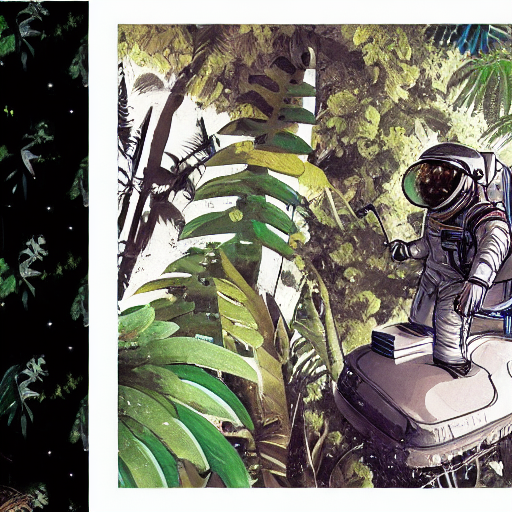

In [6]:
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

_ = generate_image(
    prompt,
    guidance_scale=7.5,
    num_inference_steps=30,
    seed=0,
)


  0%|          | 0/50 [00:00<?, ?it/s]

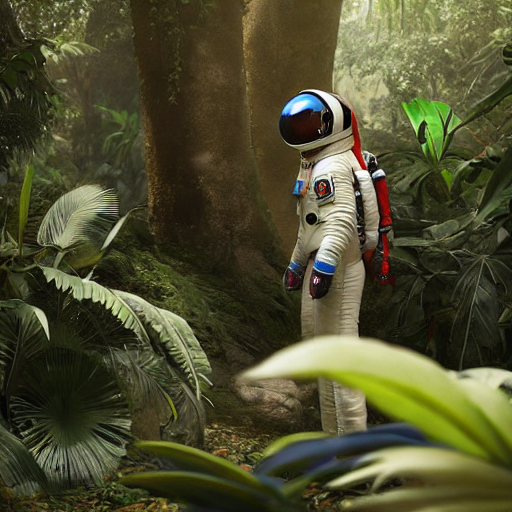

In [7]:
prompt = "Astronaut in a jungle, ultra detailed, cinematic lighting, 8k concept art"
negative = "blurry, low quality, distorted, text, watermark"

_ = generate_image(
    prompt,
    negative_prompt=negative,
    guidance_scale=9.0,      # stronger adherence to prompt
    num_inference_steps=50,  # more denoising steps = sharper
    seed=1,
)



--- Prompt 1 ---
Futuristic city at night, neon lights, rain, cinematic, 8k



  0%|          | 0/50 [00:00<?, ?it/s]

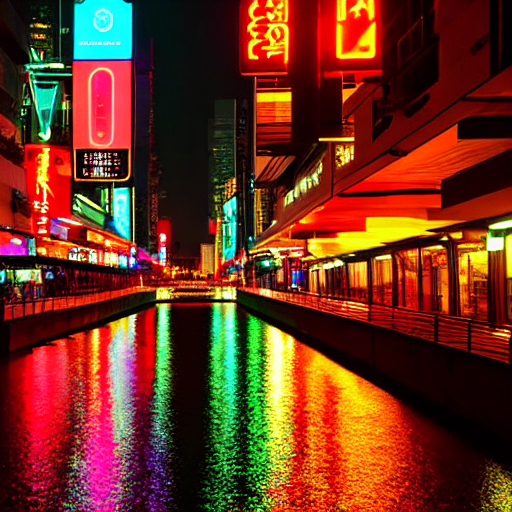


--- Prompt 2 ---
Ancient temple in a misty forest, soft lighting, highly detailed, 4k



  0%|          | 0/50 [00:00<?, ?it/s]

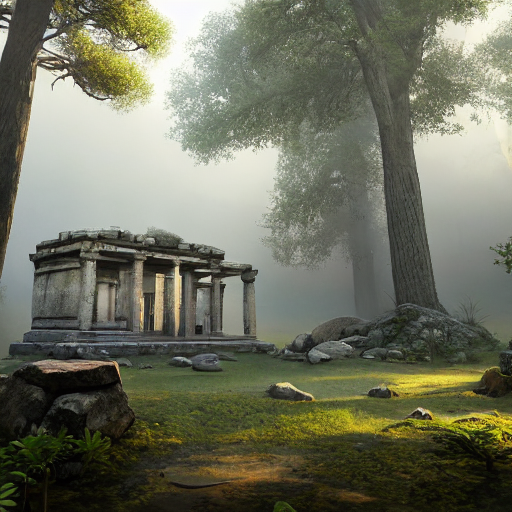


--- Prompt 3 ---
Portrait of a cyberpunk warrior, dramatic lighting, intricate armor, concept art



  0%|          | 0/50 [00:00<?, ?it/s]

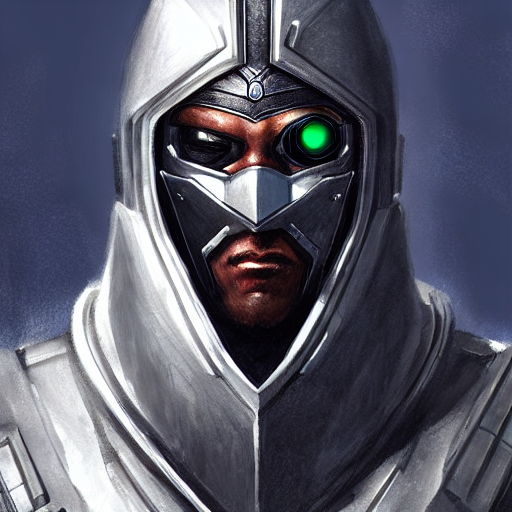

In [30]:
prompts = [
    "Futuristic city at night, neon lights, rain, cinematic, 8k",
    "Ancient temple in a misty forest, soft lighting, highly detailed, 4k",
    "Portrait of a cyberpunk warrior, dramatic lighting, intricate armor, concept art",
]

negative = "blurry, low quality, distorted, extra limbs, watermark, text"

for i, p in enumerate(prompts):
    print(f"\n--- Prompt {i+1} ---\n{p}\n")
    _ = generate_image(
        p,
        negative_prompt=negative,
        guidance_scale=9.0,
        num_inference_steps=50,
        seed=10 + i,
    )


In [31]:
from diffusers import UNet2DConditionModel
from diffusers import StableDiffusionPipeline
from diffusers import DDPMScheduler
from torch import nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Rebuild as StableDiffusionPipeline to access unet easily
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
).to(device)

# --- Simple image dataset for LoRA fine-tuning ---
class SimpleImageDataset(Dataset):
    def __init__(self, folder, size=512):
        self.paths = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        self.transform = transforms.Compose(
            [
                transforms.Resize(size, interpolation=Image.BICUBIC),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

train_folder = "/content/my_style_images"   # CHANGE THIS to your folder
dataset = SimpleImageDataset(train_folder)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [32]:
import random
from diffusers import StableDiffusionImg2ImgPipeline
from IPython.display import display

# img2img pipeline uses same base model
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
def generate_finetuned_image(
    prompt,
    strength=0.7,
    guidance_scale=9.0,
    num_inference_steps=50,
    seed=0,
):
    if len(dataset) == 0:
        raise ValueError("Your style folder is empty. Put some images in " + train_folder)

    # pick a random reference image from your dataset
    idx = random.randint(0, len(dataset) - 1)
    init_image = dataset[idx]  # PIL image, already resized

    print(f"Using reference image #{idx} from your dataset.")

    generator = torch.Generator(device=device).manual_seed(seed)

    result = img2img_pipe(
        prompt=prompt,
        image=init_image,
        strength=strength,               # how much to keep the style/structure
        guidance_scale=guidance_scale,   # how strongly to follow the text
        num_inference_steps=num_inference_steps,
        generator=generator,
    )

    out = result.images[0]


    print("Generated image:")
    display(out)

    return out



=== Prompt 1 ===
Futuristic city at night, neon lights, rain, cinematic, 8k, in my special style

Using reference image #0 from your dataset.


  0%|          | 0/35 [00:00<?, ?it/s]

Generated image:


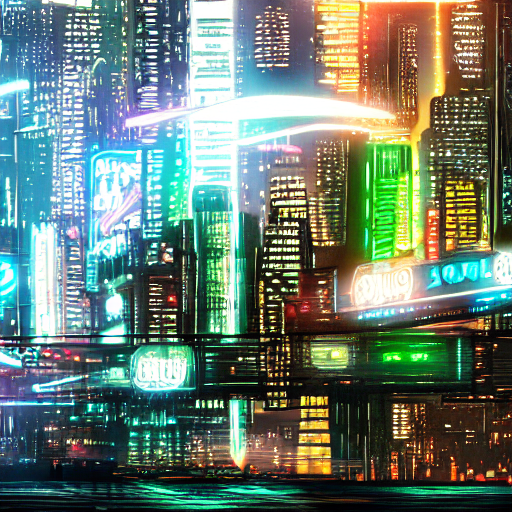


=== Prompt 2 ===
Ancient temple in a misty forest, soft lighting, highly detailed, in my special style

Using reference image #2 from your dataset.


  0%|          | 0/35 [00:00<?, ?it/s]

Generated image:


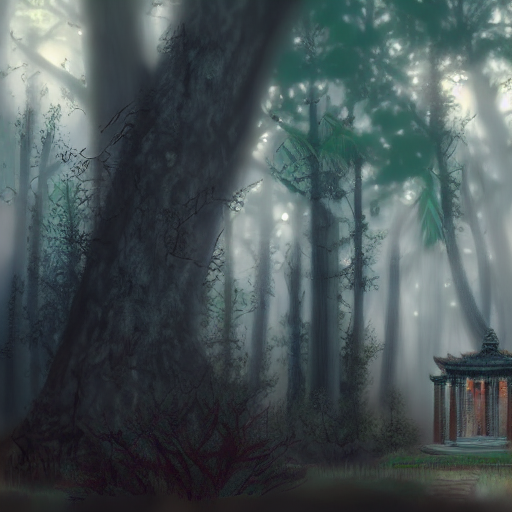


=== Prompt 3 ===
Portrait of a cyberpunk warrior, dramatic lighting, intricate armor, concept art, in my special style

Using reference image #0 from your dataset.


  0%|          | 0/35 [00:00<?, ?it/s]

Generated image:


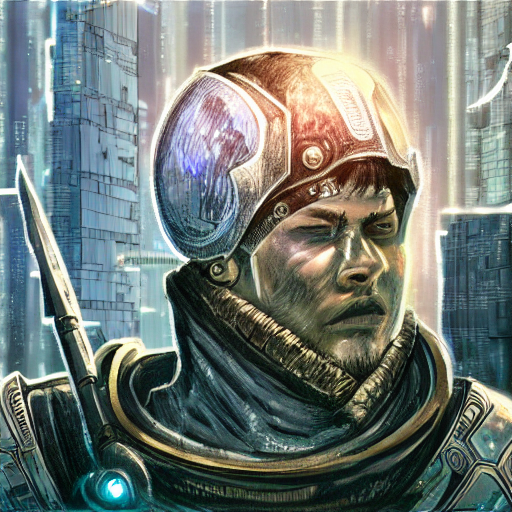

In [37]:
prompts = [
    "Futuristic city at night, neon lights, rain, cinematic, 8k, in my special style",
    "Ancient temple in a misty forest, soft lighting, highly detailed, in my special style",
    "Portrait of a cyberpunk warrior, dramatic lighting, intricate armor, concept art, in my special style",
]

for i, p in enumerate(prompts):
    print(f"\n=== Prompt {i+1} ===\n{p}\n")
    _ = generate_finetuned_image(
        prompt=p,
        strength=0.7,
        guidance_scale=9.0,
        num_inference_steps=50,
        seed=100 + i,
    )
